# Todo - will remove this section before submittion 
* change code using without for loops
* putting correct lables for all the plots

Kavya github link
https://github.com/KavyaOS/Cryptocurrency_Analysis_PricePrediction.git

Errors while running Kavya nottebook:
1.  ModuleNotFoundError: No module named 'plotly'
sol: 
pip install plotly

2. ModuleNotFoundError: No module named 'keras'

sol:
pip install keras

3. ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`
pip install tensorflow








Prof notes - 
Given that everyone going different things for the project I want you to add a short  description in your notebook. There are up to six things that I want.

First if you are working on a team then include the names and Red IDs of both team members at the top of the readme file. Just have one person submit the project so I don’t end up grading the same project twice.

Second a brief description of what the project does. What are the goals of your assignment? Did you succeed? What did you learn. In the assignments I knew what you were to do. So if you just had code and tables I could figure things out. In your project you need to explain what your code is doing and what the output of your code means. In Jupyter notebooks you can use markdown cells to contain text. Use the markdown cells to to explain your code and results as they are easier to read then comments in code. Use the markdown cells to add headers (Introduction, How to Run, Results, etc) to give the notebook some structure.  

Third any special instructions that I need to run the project. 

Fourth if you use any third party libraries list them and give the pip command needed to install them. A sentence or two on what the library does for you. If your idea comes from a site like Kaggle include a link to it. 

Fifth a list know issues with the project. If a feature is not working let me know. If a feature is not working I will grade it more severe than if you do not tell me.

Six do not upload large data files. If your total upload to the course portal is 5 MB you will be fine. If people start uploading large files to the course portal the server will crash causing you and other people in the class to panic. (I need to rewrite that server.) If you data file puts you over that limit add a command in your jupyter notebook that will  download your data file from its source. The following command in a code cell on a Unix machine will download covid data at the given https address to the local file covid.csv.


!curl -o covid.csv https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv 


If your code takes a long time to run on the original data set then I would like a smaller dataset to run while grading. If the file is small enough it can be combined with your notebook and up loaded. If not provide a method to download the file: dropbox link, Google drive link, etc. If you are not able to do this contact me to make other arrangements. Always include a link to access the original data set file.


As with assignments and the exam you will submit the project to the course portal.

#  Big Data CS649 Project -  Kavya and Sachin Kumar (RedIds - 825893660 and 823431551)

## Info

### Objective :
- Analysing the trend of crypto currency for the last few years.
- Cryptocurrency price Prediction using Deep learning. (for example ML models - Linear Regression,  K-Nearest Neighbors.)
- Analysis of social media on the crypto prize. Sentiments using few keywords in the tweets and relate with the currency price.  Positive, negative or neutral emotions.
- Our main focus would be on Twitter and Bit-coin. We can explore more currencies and platforms if time permits. 


### Datasets :
- Tweets dataset : https://www.kaggle.com/alaix14/bitcoin-tweets-20160101-to-20190329
    - Contains all the bitcoin tweets
    - date range is from 2016-Jan-01 to 2019-March-29
    
### Special Library/Packages installed : 
- TextBlob
    - pip install -U textblob
    - https://textblob.readthedocs.io/en/dev/install.html
- Language detector and translator
    - pip install google_trans_new
    - https://github.com/lushan88a/google_trans_new
- pip install pandas-profiling
- conda install graphviz
- #todo : might need to delete below packages
- pip install atoti 
- pip install atoti-aws



### Approach :


### Chalenges :
 - Not able to install few packages on windows like whatthelang
    - Language Prediction
    - https://github.com/indix/whatthelang
    - pip install -r requirements.txt
    - pip install whatthelang
 - Google translator stopped translating the tweets after certain time with below error.
    - Error - "Our systems have detected unusual traffic from your computer network"

# Running instruction

#### Packages that needs to be installed before running this notebook. Uncomment below lines once to install it and then comment it again.


In [1]:
# ! pip install -U textblob
# ! pip install google_trans_new

In [2]:
# download english stopwords, this might take little time
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sk105659\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Few configurations before running the notebook


In [3]:
######### Dataset input file path ###########################################################################
bitcoin_tweets_dataset_filepath = '../input_datasets/tweets.csv'   # Input dataset which needt to downloaded from Kaggle as given above.
  

################## Number of records to be processed from the dataset input file ###########################
# this is important as the dataset is very huge and we have many bottleneck services like - 
# 1) google lan detector
# 2) google lan translatoin, 
# 3) removing english verbose words from tweet text using stopwords from nltk.corpus
# 4) finding sentiments out of english words using TextBlob

no_of_records = 99999   # This seems to be a decent number as per our anlysis - output & performance
# no_of_records = 1000  


######### Goggle translation flag to enable english translation or not#################################
#   todo : detecotor reached to limit after certain hits
# if get this error : google_new_transError: 429 (Too Many Requests) from TTS API. then please change below flag from 0 to 1. 
# Doing so, it will not convert non-english to english lan and therefore the sentiments calucations are not 100% accurate.

# Its a common issue for all free user : https://github.com/lushan88a/google_trans_new/issues/28
# we have tried many options like giving differnt proxies and making connection using private VPN and keep switching the VPN tunnels (specially to Mexico worked) to get the desired ouput for 100000 records.

is_eng_translator_limit_reached = 0   # 0 if limit not recached, 1 if limit reached, 
is_detect_lang_required = 0           # 0 if not required , 1 if required. Turning this off is good as sometime it slows or reach to thresold limit faster than translation itself


# Also note, once the translation is done, the output would be saved on the disk. 
# and so for all the future runs, no translation is required, ranslated data would be read from the saved disk.

processed_bitcoin_tweets_dataset_filepath = './datasets/tweets_processed_v50s_eng.csv'  # Name of the file after google translation work is done once. 
# processed_bitcoin_tweets_dataset_filepath = '../input_datasets/tweets_processed_test10_eng.csv'



In [4]:
import numpy as np 
import pandas as pd 
from textblob import TextBlob
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay


def read_and_clean_input_file(input_file):
    
    # todo : using small dataset for the devlopment purpose
    bitcoin_tweets_dataset_df_raw = pd.read_csv(
        input_file, 
        sep=';',
        nrows=no_of_records,
#         dtype={'text': str},
        converters={'text': str},
        usecols=['timestamp', 'text'],                            
        index_col=["timestamp"])
    
#     display(bitcoin_tweets_dataset_df_raw)
#     display(bitcoin_tweets_dataset_df_raw.info())

    
    # Strip time information from the column 'timestamp' if any
#     bitcoin_tweets_dataset_df_raw['timestamp'] = pd.to_datetime(bitcoin_tweets_dataset_df_raw['timestamp']).dt.date
    bitcoin_tweets_dataset_df_raw.index = pd.Series(pd.to_datetime(bitcoin_tweets_dataset_df_raw.index)).dt.date
    
#     display(bitcoin_tweets_dataset_df_raw)
#     display(bitcoin_tweets_dataset_df_raw.info())
    
    # df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
    return bitcoin_tweets_dataset_df_raw


def filter_by_daterange(df):
    start_date = pd.to_datetime("2017-03-01").date()
    end_date = pd.to_datetime("2019-03-29").date()
    filtered_date_range = (df.index >= start_date) & (df.index <= end_date)
    df = df[filtered_date_range]
    ### Filter only Business day
    is_business_day = BDay().is_on_offset
    filtered_business_days = pd.to_datetime(df.index).map(is_business_day)
    df[filtered_business_days]
    return df

In [5]:
########### Below function is just for anlysing the dataset #####################################################
    
def analysing_dataset(df):
    display(df)
    display(df.info())
    display(df.index.min())
    display(df.index.max())
#     finding maximum and minimum date
    

########### Testing block #####################################################################################################
# bitcoin_tweets_dataset_df_cleaned = read_and_clean_input_file(bitcoin_tweets_dataset_filepath)
# analysing_dataset(bitcoin_tweets_dataset_df_cleaned)
# bitcoin_tweets_dataset_df_cleaned = filter_by_daterange(bitcoin_tweets_dataset_df_cleaned)
# analysing_dataset(bitcoin_tweets_dataset_df_cleaned)

In [6]:
from google_trans_new import google_translator  

# translator = google_translator()
translator = google_translator(timeout=30)
# translator = google_translator(url_suffix="https",timeout=5,proxies={'https':'206.189.44.99:8080','http':'96.9.77.203:55667','https':'140.227.68.230:58888','https':'72.196.184.54:8081' })
detector = google_translator()  

def add_english_translated_tweets_to_df(df):
    english_translated_col = []
    df['text'] = df['text'].astype(str)
    for tweet in df['text']:
        if len(tweet)!=0:
            if is_detect_lang_required == 1 :
                print("detecting lan first")
                detect_lang = detector.detect(tweet)
                if (detect_lang != ['en', 'english']) :
                    english_translated_col.append(translatoror.translate(tweet,lang_tgt='en') )
                else:
                    english_translated_col.append(tweet)
            else:
                print("detecting lan not required")
                english_translated_col.append(translator.translate(tweet,lang_tgt='en') )
        else:
            english_translated_col.append(None)

    df['english_translated'] = english_translated_col
    return df

############  Testing block  ##########################################

# function to detect lan
# detector = google_translator()  
# text = "È appena uscito un nuovo video! LES CRYPTOMONN..."
# text = "Another text which is already in english, so should not be translated."
# detect_lang = 'translate all text'
# detect_lang = detector.detect(text)
# print(detect_lang)


# function to translate the text to english
# if (detect_lang != ['en', 'english']) :
#     print(translator.translate(text,lang_tgt='en') )
# print(translator.translate(text,lang_tgt='en') )

In [7]:

def read_clean_filter_translate_write_file(input_file):
    bitcoin_tweets_dataset_df_cleaned = read_and_clean_input_file(input_file)
    bitcoin_tweets_dataset_df_cleaned = filter_by_daterange(bitcoin_tweets_dataset_df_cleaned)
    
    if(is_eng_translator_limit_reached != 1):
        bitcoin_tweets_dataset_df_cleaned = add_english_translated_tweets_to_df(bitcoin_tweets_dataset_df_cleaned)
    else:        
        bitcoin_tweets_dataset_df_cleaned['english_translated'] = bitcoin_tweets_dataset_df_cleaned['text']

    ##### Write the processed ouput to disk. This is to avoid unnecssary english translation everytime we run the program
    bitcoin_tweets_dataset_df_cleaned.to_csv(index=True, sep=',' , path_or_buf=processed_bitcoin_tweets_dataset_filepath)
#     display(bitcoin_tweets_dataset_df_cleaned)
    
    
############  Testing block  ##########################################  
# read_clean_filter_translate_write_file(bitcoin_tweets_dataset_filepath)

In [8]:
# todo: Note the seperator delimeter. orginal file has ';' and processed file has ','. 
# Should be good across complete file

import os.path
from os import path
processed_bitcoin_tweets_dataset_filepath 

if path.exists(processed_bitcoin_tweets_dataset_filepath):
    print ("processed bitcoin_tweets dataset filep exist")
else:
    print ("processed bitcoin_tweets dataset file does not exist")
    read_clean_filter_translate_write_file(bitcoin_tweets_dataset_filepath)




processed bitcoin_tweets dataset filep exist


In [9]:
processed_bitcoin_tweets_dataset_df = pd.read_csv(
        processed_bitcoin_tweets_dataset_filepath, 
        sep=',',
        dtype= {'text': str, 'english_translated': str},
        # dtype= str,
        # converters={'english_translated': str},
        index_col=["timestamp"])
    
# Strip time information from the column 'timestamp' if any
# processed_bitcoin_tweets_dataset_df['timestamp'] = pd.to_datetime(processed_bitcoin_tweets_dataset_df['timestamp']).dt.date
processed_bitcoin_tweets_dataset_df.index = pd.Series(pd.to_datetime(processed_bitcoin_tweets_dataset_df.index)).dt.date
display(processed_bitcoin_tweets_dataset_df)


# Filter the dates between a range which is common to both dataframes - tweets dataframe and price dataframe
processed_bitcoin_tweets_dataset_df = filter_by_daterange(processed_bitcoin_tweets_dataset_df)
# processed_bitcoin_tweets_dataset_df = processed_bitcoin_tweets_dataset_df.sort_index()   -- no need to sort. that is just for verification and display purpose, if needed.

display(processed_bitcoin_tweets_dataset_df.sample(10))
print('min date is ',processed_bitcoin_tweets_dataset_df.index.min())
print('max date is ',processed_bitcoin_tweets_dataset_df.index.max())

,text,english_translated
timestamp,,
2019-03-12,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...
2018-09-11,I didnt tether at $7300 #iamspartacus\n$btc $e...,I didnt tether at $7300 #iamspartacus\n$btc $e...
2019-03-21,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...
2019-03-09,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...
2019-03-12,#Bitcoin #crypto #Airdrop\nNew Airdrop #p2pb2b...,#Bitcoin #crypto #Airdrop\nNew Airdrop #p2pb2b...
...,...,...
2018-12-28,"How the ""Times"" have changed - great to see su...","How the ""Times"" have changed - great to see su..."
2019-03-08,My weekly #Bitcoin and #crypto report for Bitc...,My weekly #Bitcoin and #crypto report for Bitc...
2018-12-25,Why gift cards are scams:\n1) turns liquid cas...,Why gift cards are scams:\n1) turns liquid cas...


,text,english_translated
timestamp,,
2018-09-02,Volume changes in last 10 minutes:\nBinance:\n...,Volume changes in last 10 minutes:\nBinance:\n...
2018-04-12,This 5th WAVE can technically hit $7250.00 or ...,This 5th WAVE can technically hit $7250.00 or ...
2019-01-26,"“Umm, State Payments! ” -> http://ow.ly/ebV330...","“Umm, State Payments! ” -> http://ow.ly/ebV330..."
2018-08-18,#cryptocurrency Price Analysis for #Bitsend #B...,#cryptocurrency Price Analysis for #Bitsend #B...
2018-07-09,"Korea price\nTime: 07/09 20:10:00\nBTC: 7,498,...","Korea price\nTime: 07/09 20:10:00\nBTC: 7,498,..."
2018-05-17,Next Game Available Odds 272.00 All Intersted ...,Next Game Available Odds 272.00 All Intersted ...
2018-01-14,#BTC #Mining #Zcash #Ether #Monero #SHA-256 #S...,#BTC #Mining #Zcash #Ether #Monero #SHA-256 #S...
2018-11-23,": 1 BTC @ 22:00 CET: 3,949.46€ (+16.07) / $4,5...",": 1 btc @ 22:00 CET: 3,949.46 € (+16.07) / $ 4..."
2019-02-27,"Preços Bank To Crypto:\n\nBITCOIN: R$ 14.673,0...","Preços Bank To Crypto:\n\nBITCOIN: R$ 14.673,0..."


min date is  2017-05-24
max date is  2019-03-29


In [10]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

""" Utility function to clean tweet text by removing special characters and links using regex"""
def clean_special_chars(text):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)", " ", text).split())


""" Utility function to clean tweet text and remove verbose english words using nltk stopwords"""
def clean_and_remove_english_verbose_words(text):
    text = clean_special_chars(text)
    forbidden_words = set(stopwords.words('english'))
    text = ' '.join(text.split('.'))
    text = re.sub('\/',' ',text)
    text = text.strip('\'"')
    text = re.sub(r'@([^\s]+)',r'\1',text)
    text = re.sub(r'\\',' ',text)
    text = text.lower()
    text = re.sub('[\s]+', ' ', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub(r'((http)\S+)','',text)
    text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
    text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
    text = [word for word in text.split() if word not in forbidden_words]
    return ' '.join(text)


""" Utility function to classify sentiment of passed tweet using textblob's sentiment method """
def sentiment(text):
    # create TextBlob object of passed tweet text
    text_analysis = TextBlob(text)
    return text_analysis.sentiment.polarity



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sk105659\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from textblob import TextBlob

""" Utility function to classify sentiment of passed tweet using textblob's sentiment method """
def add_eng_keywords_and_sentiments(df):
    english_keywords_col = []
    sentiment_col = []
    for tweet in df['english_translated']:
        
        # If running stopwords on big data slows donw the speed, then we can skip stopwords logic for performance and only use the simple cleaning of special chars
        english_keywords = clean_and_remove_english_verbose_words(tweet)
        #   english_keywords = clean_special_chars(tweet)
        english_keywords_col.append(english_keywords)
        
        # Add corresponding sentiments
        sentiment_polarity = sentiment(tweet)
        sentiment_col.append(sentiment_polarity)
    
    df['english_keywords'] = english_keywords_col
    df['sentiment'] = sentiment_col
    return df


# processed_bitcoin_tweets_dataset_df['english_keywords'] = processed_bitcoin_tweets_dataset_df['english_translated'].apply(lambda text: clean_and_remove_english_verbose_words(text))
# processed_bitcoin_tweets_dataset_df['sentiment'] = processed_bitcoin_tweets_dataset_df['english_keywords'].apply(lambda text: sentiment(text)) # new column of sentiment
# processed_bitcoin_tweets_dataset_df.drop(columns='english_translated', inplace=True)

processed_bitcoin_tweets_dataset_df = add_eng_keywords_and_sentiments(processed_bitcoin_tweets_dataset_df)
processed_bitcoin_tweets_dataset_df.sample(10)


,text,english_translated,english_keywords,sentiment
timestamp,,,,
2018-10-20,ツイート数の多かった仮想通貨\n1位 $BTC 536 Tweets\n2位 $TRX 17...,Virtual currency that has many tweets 1st pla...,virtual currency many tweets st place btc twee...,0.166667
2018-04-27,#BTC Average: 9228.97$\n\n#Bitfinex - 9245.00$...,#BTC Average: 9228.97$\n\n#Bitfinex - 9245.00$...,btc average bitfinex poloniex bitstamp coinbas...,-0.150000
2018-09-24,"Bitcoin-Hourly Club - почасовой хайп, от 4.36%...","Bitcoin-Hourly Club - Hourly High, from 4.36% ...",bitcoin hourly club hourly high every hour usd...,0.160000
2018-09-26,Top 5 #cryptocurrencies \n Alert Time: 2018-09...,Top 5 #cryptocurrencies \n Alert Time: 2018-09...,top cryptocurrencies alert time bitcoin ethere...,0.500000
2019-03-28,Bittrex - Volume changed on PlayChip (BTC/PLA)...,Bittrex - Volume changed on PlayChip (BTC/PLA)...,bittrex volume changed playchip btc pla price ...,0.000000
2017-10-28,"Previsão da Notell, mantida de um Bitcoin a U$...","Notewise forecast, maintained from a Bitcoin a...",notewise forecast maintained bitcoin mid november,0.000000
2018-09-03,Top 5 #cryptocurrencies \n Alert Time: 2018-09...,Top 5 #cryptocurrencies \n Alert Time: 2018-09...,top cryptocurrencies alert time bitcoin ethere...,0.500000
2019-03-02,Appearing in more publications. We are on the ...,Appearing in more publications. We are on the ...,appearing publications good way block blockcha...,0.687500
2018-07-31,Precios de #CoinMarketCap al día 31-07-2018 a ...,Precios de #CoinMarketCap al día 31-07-2018 a ...,precios de coinmarketcap al las top crypto lio...,0.000000


In [12]:
# # Filter the dates between a range which is common to both dataframes - tweets dataframe and price dataframe
# processed_bitcoin_tweets_dataset_df = filter_by_daterange(processed_bitcoin_tweets_dataset_df)
# # processed_bitcoin_tweets_dataset_df = processed_bitcoin_tweets_dataset_df.sort_index()   -- no need to sort. that is just for verification and display purpose, if needed.
# processed_bitcoin_tweets_dataset_df.sample(10)

In [13]:
# considering the average tweet sentiment of the day.
# df = df.groupby(df.index).agg(lambda x: x.value_counts().index[0])
#  todo: played with first, max, min, mean. i think mean is the best one for this.
bitcoin_tweets_sentiment_df = processed_bitcoin_tweets_dataset_df.groupby(processed_bitcoin_tweets_dataset_df.index).min()
bitcoin_tweets_sentiment_df

,text,english_translated,english_keywords,sentiment
timestamp,,,,
2017-05-24,So @Bitcoin just broke $2400.00 ea thanks to J...,So @Bitcoin just broke $2400.00 ea thanks to J...,broke ea thanks japan legislation good day enc...,0.450000
2017-05-25,#Bitcoin #thatBitcoinlife will provide everyth...,#Bitcoin #thatBitcoinlife will provide everyth...,bitcoin thatbitcoinlife provide everything tho...,0.000000
2017-06-06,New all time #bitstamp #bitcoin high of $2787.00,New all time #bitstamp #bitcoin high of $2787.00,new time bitstamp bitcoin high,0.148182
2017-06-22,"JNECare: wprameswari_15 Hi kak, admin cek kiri...","JNE Care: PRAMESWARI 15 HI Sis, Admin Checks t...",jne care prameswari hi sis admin checks shipme...,0.000000
2017-06-30,historic btc price on July 4th\n2016: +6.00% \...,historic btc price on July 4th\n2016: +6.00% \...,historic btc price july th,0.000000
...,...,...,...,...
2019-03-25,Oh shit! Still time to buy $btc for lunch in 1...,Oh shit! Still time to buy $btc for lunch in 1...,oh shit still time buy btc lunch min every day...,-0.250000
2019-03-26,"₿1 = $3,951 (00:56 UTC)\n$BTC prices rise!\n#...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed globalcoin btc glc pric...,-0.500000
2019-03-27,#BTT در @Coinsuper_OFCL در دسترس است، شما میتو...,#BTT was listed in @CoInSuper_OFCL. #BTT can b...,bittrex volume changed bitstarcoin btc bits pr...,0.000000


In [14]:
###################### from other notebook #######################
%store -r big_frame
big_frame

,Date,Price,Open,High,Low,Volume,Change,coin_name_abbrv,coin_name
0,2021-04-25,498.37000,497.46000,504.23000,486.09000,2.04,0.18%,Bin,Binance
1,2021-04-24,497.50000,526.52000,527.18000,483.39000,3.16,-5.52%,Bin,Binance
2,2021-04-23,526.56000,505.12000,529.95000,450.94000,7.19,4.10%,Bin,Binance
3,2021-04-22,505.84000,543.30000,582.15000,482.81000,6.69,-6.90%,Bin,Binance
4,2021-04-21,543.34000,587.45000,612.86000,537.64000,5.96,-7.52%,Bin,Binance
...,...,...,...,...,...,...,...,...,...
16764,2015-01-26,0.01469,0.01700,0.01750,0.01469,0.00,-13.59%,XRP,XRP
16765,2015-01-25,0.01700,0.01739,0.01739,0.01560,0.00,-2.24%,XRP,XRP
16766,2015-01-24,0.01739,0.01600,0.01739,0.01500,0.00,8.69%,XRP,XRP
16767,2015-01-23,0.01600,0.01602,0.01700,0.01600,0.00,-0.12%,XRP,XRP


In [15]:
bitcoin_price_df = big_frame.query("coin_name == 'Bitcoin'")
# todo : remove warning.. ... 
df1 = bitcoin_price_df['Date']
x2  = bitcoin_price_df.loc[:,['Date']]
x2
bitcoin_price_df['Date'] = pd.to_datetime(df1).dt.date
# bitcoin_price_df['Date'] = pd.to_datetime(x2).dt.date
# bitcoin_price_df['Date'] = pd.to_datetime(x2.stack())

bitcoin_price_df = bitcoin_price_df.set_index(['Date'])
display(bitcoin_price_df)
# display(bitcoin_price_df.info())

# Filter the dates between a range. This is common to both dataframes - tweets dataframe and price dataframe
bitcoin_price_df = filter_by_daterange(bitcoin_price_df)
# bitcoin_price_df = bitcoin_price_df['Price'].to_frame()
bitcoin_price_df = bitcoin_price_df[['Price', 'Change']]
display(bitcoin_price_df)
display(type(bitcoin_price_df))
# display(bitcoin_price_df.info())

<ipython-input-15-b2ce8a990481>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_price_df['Date'] = pd.to_datetime(df1).dt.date


,Price,Open,High,Low,Volume,Change,coin_name_abbrv,coin_name
Date,,,,,,,,
2021-04-25,49561.9,50088.2,50438.8,49226.5,0.06626,-1.05%,Bit,Bitcoin
2021-04-24,50088.9,51140.8,51183.0,48775.2,0.08225,-2.06%,Bit,Bitcoin
2021-04-23,51143.6,51707.1,52099.9,47659.4,0.21446,-1.13%,Bit,Bitcoin
2021-04-22,51729.5,53821.3,55408.4,50590.9,0.16813,-3.88%,Bit,Bitcoin
2021-04-21,53820.2,56479.5,56764.4,53657.6,0.10026,-4.71%,Bit,Bitcoin
...,...,...,...,...,...,...,...,...
2010-07-22,0.1,0.1,0.1,0.1,0.00216,0.00%,Bit,Bitcoin
2010-07-21,0.1,0.1,0.1,0.1,0.00058,0.00%,Bit,Bitcoin
2010-07-20,0.1,0.1,0.1,0.1,0.00026,0.00%,Bit,Bitcoin


,Price,Change
Date,,
2019-03-29,4102.2,1.90%
2019-03-28,4025.6,-0.40%
2019-03-27,4041.7,2.51%
2019-03-26,3942.8,0.15%
2019-03-25,3937.0,-1.44%
...,...,...
2017-03-05,1271.2,0.55%
2017-03-04,1264.3,-1.48%
2017-03-03,1283.3,2.22%


pandas.core.frame.DataFrame

In [16]:
def merge_bitcoin_price_and_tweets_data(bitcoin_price_df, bitcoin_tweets_sentiment_df):
    #Combine two dataframes based on time.
    df = pd.merge(bitcoin_price_df, bitcoin_tweets_sentiment_df, left_index=True, right_index=True, how='inner')
    return df

def make_sentiment_column_categorical(bitcoin_price_sentiment):
    # Adding 'Sentiment categorical' column.
    bitcoin_price_sentiment['sentiment_cat'] = bitcoin_price_sentiment['sentiment'].astype('category')
    bitcoin_price_sentiment['sentiment_cat'] = bitcoin_price_sentiment['sentiment_cat'].cat.codes
    return bitcoin_price_sentiment


bitcoin_price_sentiment  = merge_bitcoin_price_and_tweets_data(bitcoin_price_df, bitcoin_tweets_sentiment_df)
bitcoin_price_sentiment['sentiment_scaled'] = bitcoin_price_sentiment['sentiment'] * 10000
bitcoin_price_sentiment = make_sentiment_column_categorical(bitcoin_price_sentiment)
bitcoin_price_sentiment

,Price,Change,text,english_translated,english_keywords,sentiment,sentiment_scaled,sentiment_cat
2019-03-29,4102.2,1.90%,"₿1 = $4,136 (00:28 UTC)\n$BTC prices continue...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed counterparty btc xcp pr...,-0.221212,-2212.121212,17
2019-03-28,4025.6,-0.40%,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,bittrex volume changed folding coin btc fldc p...,0.000000,0.000000,50
2019-03-27,4041.7,2.51%,#BTT در @Coinsuper_OFCL در دسترس است، شما میتو...,#BTT was listed in @CoInSuper_OFCL. #BTT can b...,bittrex volume changed bitstarcoin btc bits pr...,0.000000,0.000000,50
2019-03-26,3942.8,0.15%,"₿1 = $3,951 (00:56 UTC)\n$BTC prices rise!\n#...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed globalcoin btc glc pric...,-0.500000,-5000.000000,4
2019-03-25,3937.0,-1.44%,Oh shit! Still time to buy $btc for lunch in 1...,Oh shit! Still time to buy $btc for lunch in 1...,oh shit still time buy btc lunch min every day...,-0.250000,-2500.000000,15
...,...,...,...,...,...,...,...,...
2017-06-30,2480.6,-3.04%,historic btc price on July 4th\n2016: +6.00% \...,historic btc price on July 4th\n2016: +6.00% \...,historic btc price july th,0.000000,0.000000,50
2017-06-22,2722.8,1.69%,"JNECare: wprameswari_15 Hi kak, admin cek kiri...","JNE Care: PRAMESWARI 15 HI Sis, Admin Checks t...",jne care prameswari hi sis admin checks shipme...,0.000000,0.000000,50
2017-06-06,2870.5,6.12%,New all time #bitstamp #bitcoin high of $2787.00,New all time #bitstamp #bitcoin high of $2787.00,new time bitstamp bitcoin high,0.148182,1481.818182,59
2017-05-25,2307.2,-5.65%,#Bitcoin #thatBitcoinlife will provide everyth...,#Bitcoin #thatBitcoinlife will provide everyth...,bitcoin thatbitcoinlife provide everything tho...,0.000000,0.000000,50


In [17]:
def plot_two_lines(line1, line2, label1=None, label2=None, title='', xlabel=None, ylabel=None, legend_loc='best', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc=legend_loc, fontsize=16)

def plot_one_line(line1, label1=None, title='', xlabel=None, ylabel=None, legend_loc='best', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc=legend_loc, fontsize=16)

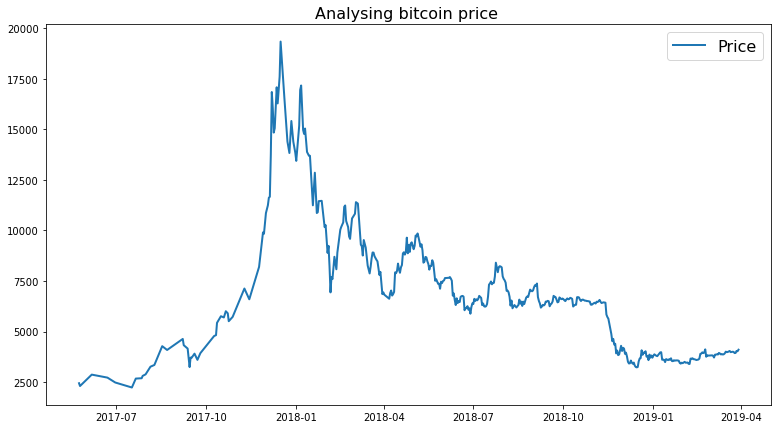

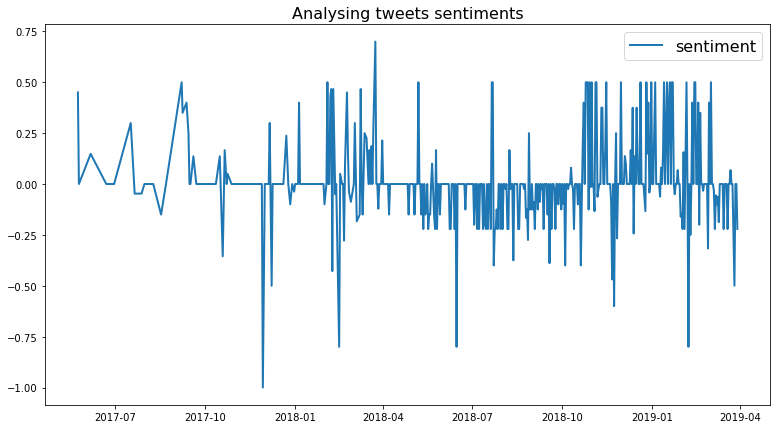

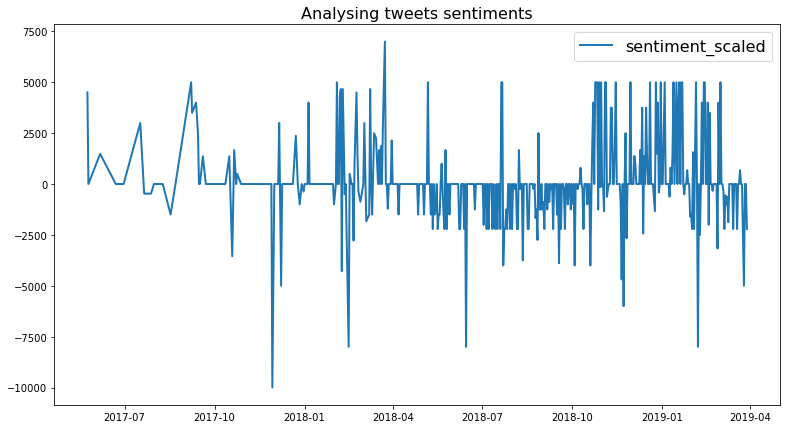

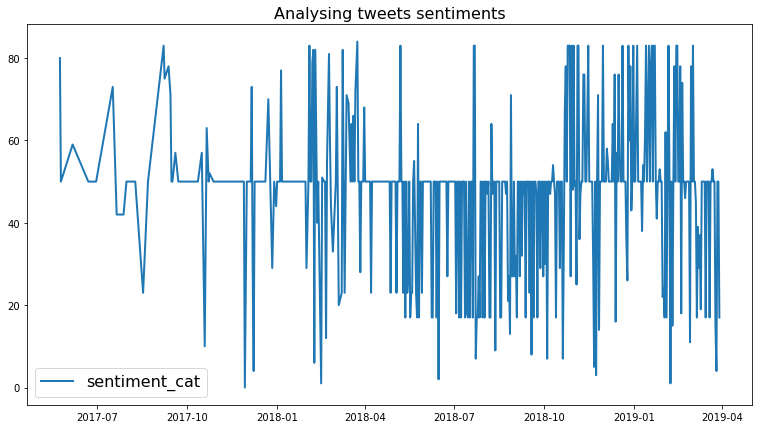

In [18]:
plot_one_line(bitcoin_price_sentiment['Price'], 'Price', title='Analysing bitcoin price ')
plot_one_line(bitcoin_price_sentiment['sentiment'] , 'sentiment', title='Analysing tweets sentiments')
plot_one_line(bitcoin_price_sentiment['sentiment_scaled'] , 'sentiment_scaled', title='Analysing tweets sentiments')
plot_one_line(bitcoin_price_sentiment['sentiment_cat'] , 'sentiment_cat', title='Analysing tweets sentiments')

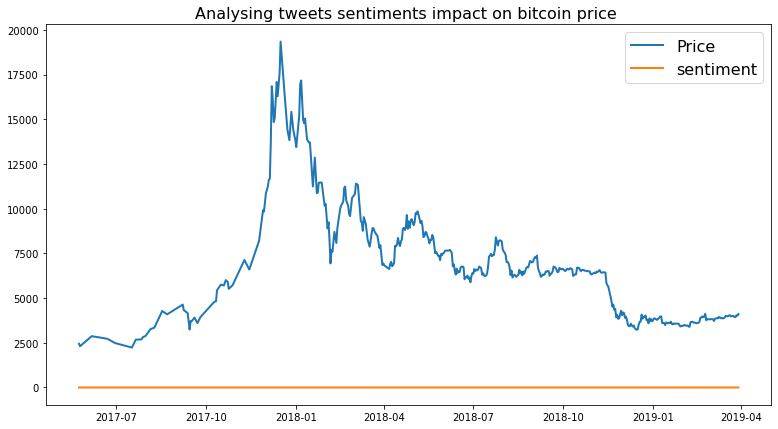

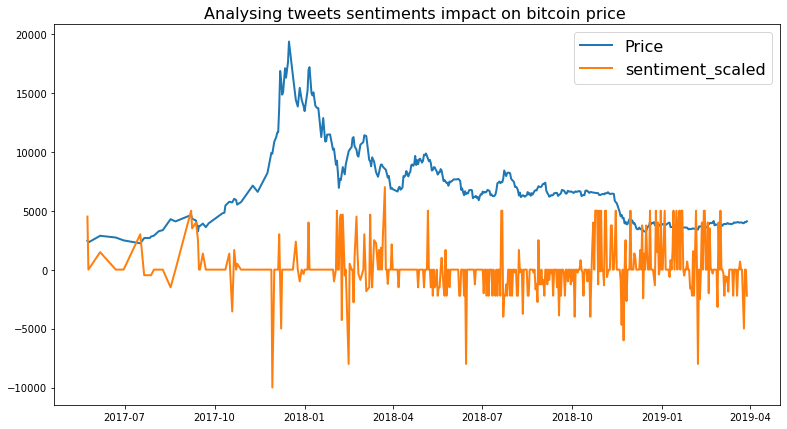

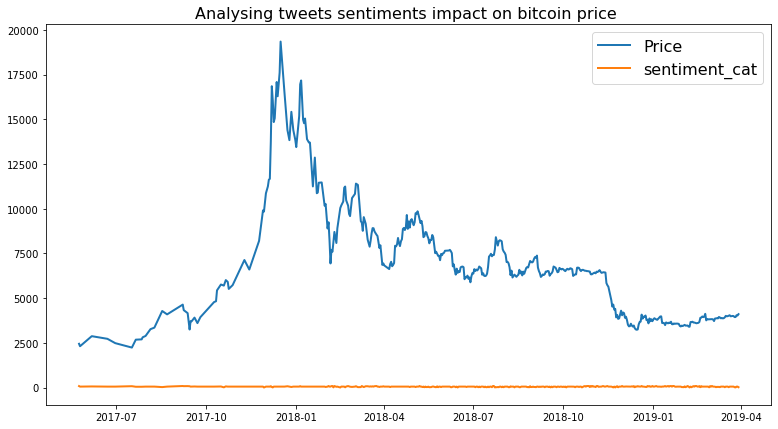

In [19]:
plot_two_lines(bitcoin_price_sentiment['Price'], bitcoin_price_sentiment['sentiment'], 'Price', 'sentiment', title='Analysing tweets sentiments impact on bitcoin price ')
plot_two_lines(bitcoin_price_sentiment['Price'], bitcoin_price_sentiment['sentiment_scaled'], 'Price', 'sentiment_scaled', title='Analysing tweets sentiments impact on bitcoin price ')
plot_two_lines(bitcoin_price_sentiment['Price'], bitcoin_price_sentiment['sentiment_cat'], 'Price', 'sentiment_cat', title='Analysing tweets sentiments impact on bitcoin price ')

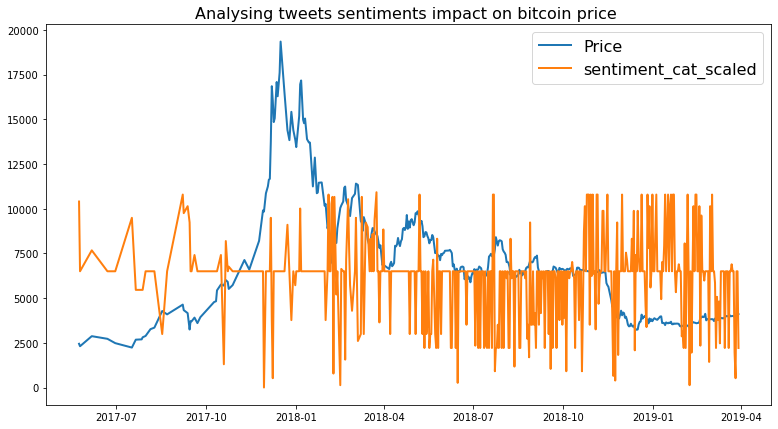

In [20]:
bitcoin_price_sentiment['sentiment_cat_scaled'] = bitcoin_price_sentiment['sentiment_cat'] * 130
plot_two_lines(bitcoin_price_sentiment['Price'], bitcoin_price_sentiment['sentiment_cat_scaled'], 'Price', 'sentiment_cat_scaled', title='Analysing tweets sentiments impact on bitcoin price ')

# plot_two_lines(bitcoin_price_sentiment['Change'], bitcoin_price_sentiment['sentiment'], 'Change', 'sentiment_cat', title='Analysing tweets sentiments impact on bitcoin price ')



In [21]:
bitcoin_price_sentiment

,Price,Change,text,english_translated,english_keywords,sentiment,sentiment_scaled,sentiment_cat,sentiment_cat_scaled
2019-03-29,4102.2,1.90%,"₿1 = $4,136 (00:28 UTC)\n$BTC prices continue...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed counterparty btc xcp pr...,-0.221212,-2212.121212,17,2210
2019-03-28,4025.6,-0.40%,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,bittrex volume changed folding coin btc fldc p...,0.000000,0.000000,50,6500
2019-03-27,4041.7,2.51%,#BTT در @Coinsuper_OFCL در دسترس است، شما میتو...,#BTT was listed in @CoInSuper_OFCL. #BTT can b...,bittrex volume changed bitstarcoin btc bits pr...,0.000000,0.000000,50,6500
2019-03-26,3942.8,0.15%,"₿1 = $3,951 (00:56 UTC)\n$BTC prices rise!\n#...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed globalcoin btc glc pric...,-0.500000,-5000.000000,4,520
2019-03-25,3937.0,-1.44%,Oh shit! Still time to buy $btc for lunch in 1...,Oh shit! Still time to buy $btc for lunch in 1...,oh shit still time buy btc lunch min every day...,-0.250000,-2500.000000,15,1950
...,...,...,...,...,...,...,...,...,...
2017-06-30,2480.6,-3.04%,historic btc price on July 4th\n2016: +6.00% \...,historic btc price on July 4th\n2016: +6.00% \...,historic btc price july th,0.000000,0.000000,50,6500
2017-06-22,2722.8,1.69%,"JNECare: wprameswari_15 Hi kak, admin cek kiri...","JNE Care: PRAMESWARI 15 HI Sis, Admin Checks t...",jne care prameswari hi sis admin checks shipme...,0.000000,0.000000,50,6500
2017-06-06,2870.5,6.12%,New all time #bitstamp #bitcoin high of $2787.00,New all time #bitstamp #bitcoin high of $2787.00,new time bitstamp bitcoin high,0.148182,1481.818182,59,7670
2017-05-25,2307.2,-5.65%,#Bitcoin #thatBitcoinlife will provide everyth...,#Bitcoin #thatBitcoinlife will provide everyth...,bitcoin thatbitcoinlife provide everything tho...,0.000000,0.000000,50,6500


In [22]:
def get_tweet_sentiment_nature(tweet_polarity):
    # set sentiment
    if tweet_polarity > 0:
        return 'positive'
    elif tweet_polarity == 0:
        return 'neutral'
    else:
        return 'negative'
    
bitcoin_price_sentiment['sentiment_nature'] = bitcoin_price_sentiment['sentiment'].apply(lambda tweet_polarity: get_tweet_sentiment_nature(tweet_polarity))    
bitcoin_price_sentiment

,Price,Change,text,english_translated,english_keywords,sentiment,sentiment_scaled,sentiment_cat,sentiment_cat_scaled,sentiment_nature
2019-03-29,4102.2,1.90%,"₿1 = $4,136 (00:28 UTC)\n$BTC prices continue...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed counterparty btc xcp pr...,-0.221212,-2212.121212,17,2210,negative
2019-03-28,4025.6,-0.40%,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,And we deserved it :)\n\n#agrocoin #LATOKEN #a...,bittrex volume changed folding coin btc fldc p...,0.000000,0.000000,50,6500,neutral
2019-03-27,4041.7,2.51%,#BTT در @Coinsuper_OFCL در دسترس است، شما میتو...,#BTT was listed in @CoInSuper_OFCL. #BTT can b...,bittrex volume changed bitstarcoin btc bits pr...,0.000000,0.000000,50,6500,neutral
2019-03-26,3942.8,0.15%,"₿1 = $3,951 (00:56 UTC)\n$BTC prices rise!\n#...",#cryptocurrency Price Analysis for #Bitsend #B...,bittrex volume changed globalcoin btc glc pric...,-0.500000,-5000.000000,4,520,negative
2019-03-25,3937.0,-1.44%,Oh shit! Still time to buy $btc for lunch in 1...,Oh shit! Still time to buy $btc for lunch in 1...,oh shit still time buy btc lunch min every day...,-0.250000,-2500.000000,15,1950,negative
...,...,...,...,...,...,...,...,...,...,...
2017-06-30,2480.6,-3.04%,historic btc price on July 4th\n2016: +6.00% \...,historic btc price on July 4th\n2016: +6.00% \...,historic btc price july th,0.000000,0.000000,50,6500,neutral
2017-06-22,2722.8,1.69%,"JNECare: wprameswari_15 Hi kak, admin cek kiri...","JNE Care: PRAMESWARI 15 HI Sis, Admin Checks t...",jne care prameswari hi sis admin checks shipme...,0.000000,0.000000,50,6500,neutral
2017-06-06,2870.5,6.12%,New all time #bitstamp #bitcoin high of $2787.00,New all time #bitstamp #bitcoin high of $2787.00,new time bitstamp bitcoin high,0.148182,1481.818182,59,7670,positive
2017-05-25,2307.2,-5.65%,#Bitcoin #thatBitcoinlife will provide everyth...,#Bitcoin #thatBitcoinlife will provide everyth...,bitcoin thatbitcoinlife provide everything tho...,0.000000,0.000000,50,6500,neutral


In [23]:
print("\n Cleaned tweets count = ", bitcoin_tweets_sentiment_df.sentiment.count())
print("\n Cleaned bitcoin_price count = ", bitcoin_price_df.Price.count())
print("\n Cleaned merged df count = ", bitcoin_price_sentiment.Price.count())



 Cleaned tweets count =  463

 Cleaned bitcoin_price count =  759

 Cleaned merged df count =  463


In [24]:
analysis = bitcoin_price_sentiment.drop(columns=['Price','text', 'english_translated', 'english_keywords', 'sentiment_scaled', 'sentiment_cat_scaled'])
analysis['Change'] = analysis['Change'].str.replace('%', '').astype(float)
display(analysis)
display(analysis.info())

,Change,sentiment,sentiment_cat,sentiment_nature
2019-03-29,1.90,-0.221212,17,negative
2019-03-28,-0.40,0.000000,50,neutral
2019-03-27,2.51,0.000000,50,neutral
2019-03-26,0.15,-0.500000,4,negative
2019-03-25,-1.44,-0.250000,15,negative
...,...,...,...,...
2017-06-30,-3.04,0.000000,50,neutral
2017-06-22,1.69,0.000000,50,neutral
2017-06-06,6.12,0.148182,59,positive
2017-05-25,-5.65,0.000000,50,neutral


<class 'pandas.core.frame.DataFrame'>
Index: 463 entries, 2019-03-29 to 2017-05-24
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Change            463 non-null    float64
 1   sentiment         463 non-null    float64
 2   sentiment_cat     463 non-null    int8   
 3   sentiment_nature  463 non-null    object 
dtypes: float64(2), int8(1), object(1)
memory usage: 14.9+ KB


None

In [25]:
grouped_sentiment_price_change = analysis.groupby(['sentiment_nature'], as_index=False)
mean_bitcoin_price_change = grouped_sentiment_price_change.mean()
print("\nMean of bitcoin price change per sentiment")
print(mean_bitcoin_price_change)


stddev_bitcoin_price_change = grouped_sentiment_price_change['Change'].apply(lambda x: x.std())
print("\nStddev of bitcoin price change per sentiment")
print(stddev_bitcoin_price_change)


Mean of bitcoin price change per sentiment
  sentiment_nature    Change  sentiment  sentiment_cat
0         negative  0.329683  -0.194557      23.746032
1          neutral  0.016255   0.000000      50.000000
2         positive  0.392209   0.334011      72.732558

Stddev of bitcoin price change per sentiment
  sentiment_nature    Change
0         negative  3.806280
1          neutral  4.145568
2         positive  5.089519


<AxesSubplot:xlabel='sentiment_nature', ylabel='Change'>

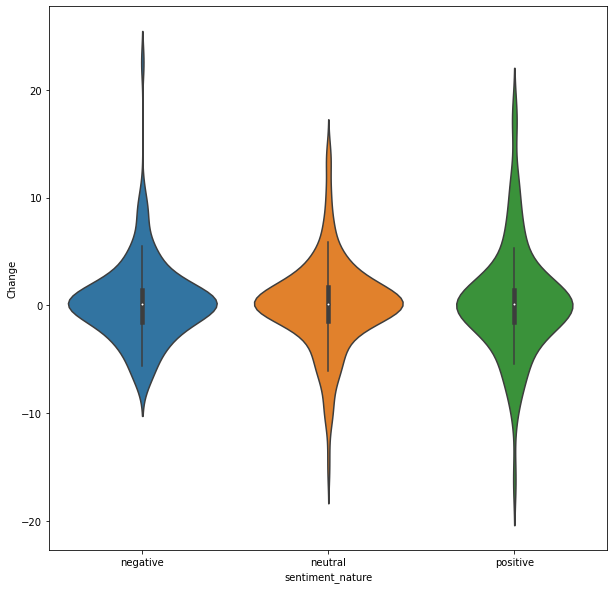

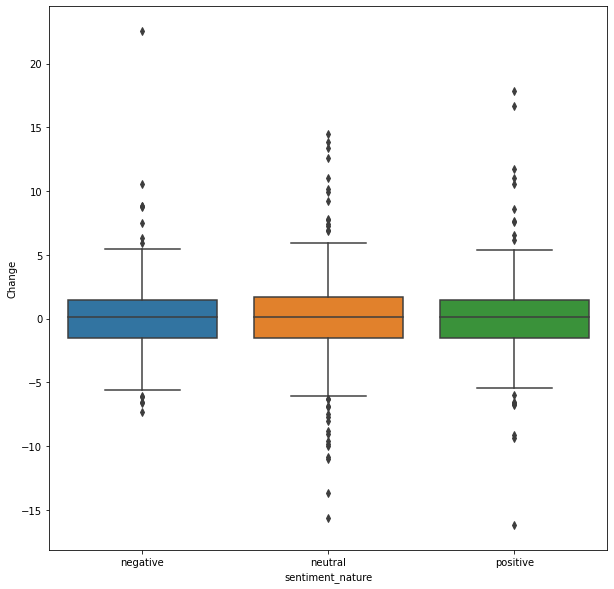

In [26]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.violinplot(x=analysis.sentiment_nature, y=analysis.Change, data=analysis, height=8)


plt.figure(figsize=(10, 10))
sns.boxplot(data=analysis, x=analysis.sentiment_nature, y=analysis.Change)

<AxesSubplot:>

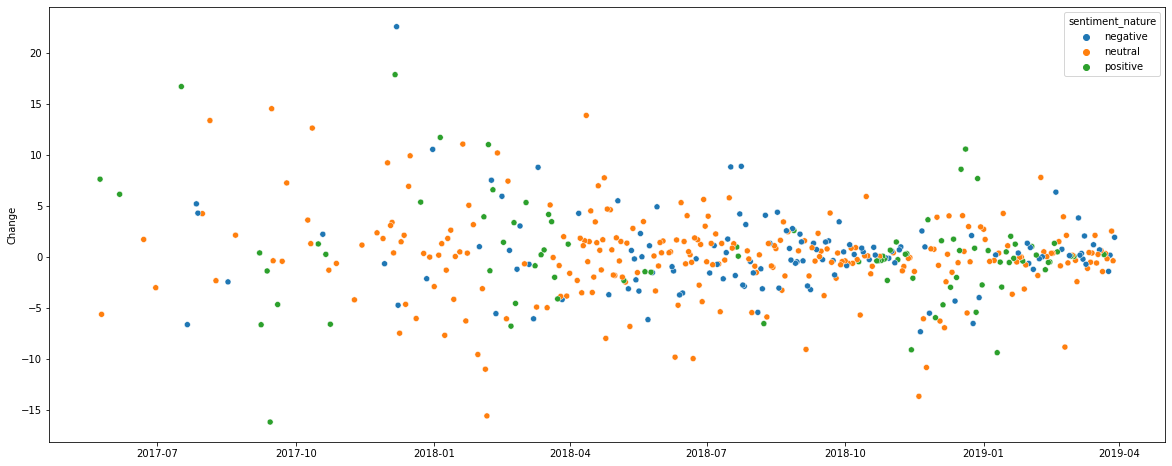

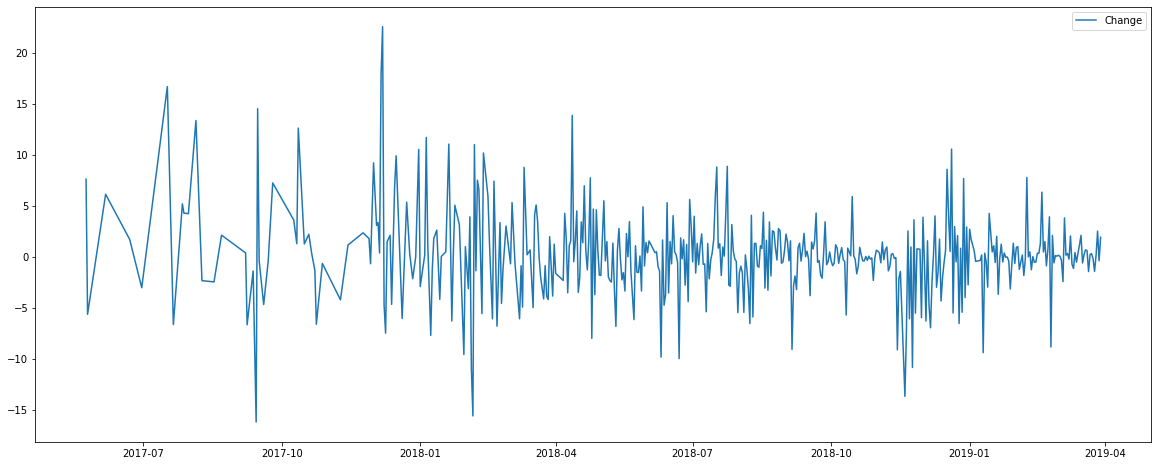

In [27]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x=analysis.index, y=analysis['Change'], data=analysis, hue=analysis['sentiment_nature']);
analysis[['Change']].plot(figsize=(20, 8))

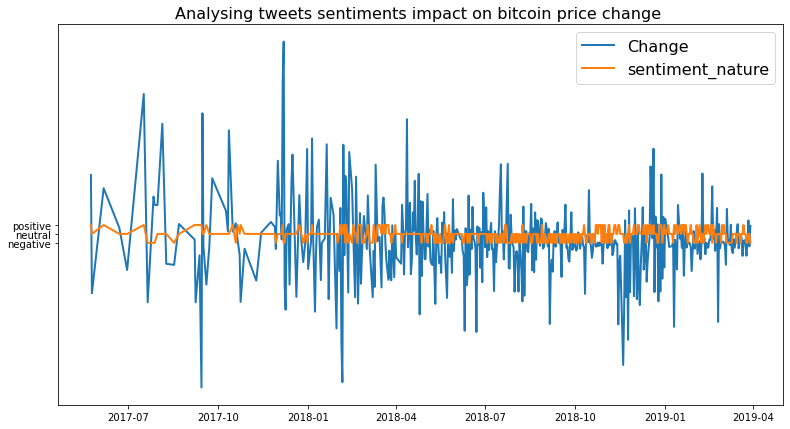

In [28]:
plot_two_lines(analysis['Change'], analysis['sentiment_nature'], 'Change', 'sentiment_nature', title='Analysing tweets sentiments impact on bitcoin price change ')


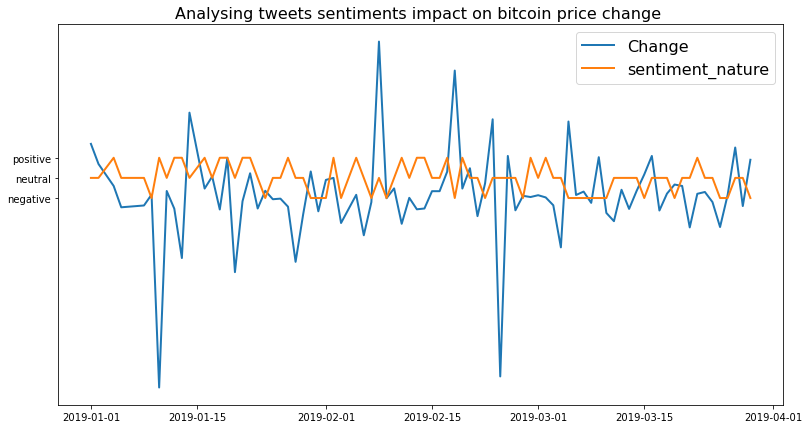

In [29]:
def filter_by_daterange(df, start_date, end_date):
    filtered_date_range = (df.index >= start_date) & (df.index <= end_date)
    return df[filtered_date_range]


start_date = pd.to_datetime("2019-01-01").date()
end_date = pd.to_datetime("2019-03-29").date()
analysing_filtered = filter_by_daterange(analysis, start_date, end_date)

plot_two_lines(analysing_filtered['Change'], analysing_filtered['sentiment_nature'], 'Change', 'sentiment_nature', title='Analysing tweets sentiments impact on bitcoin price change ')
